In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

%matplotlib notebook

In [2]:
def evolve3D(grid, b, num_steps=1):
    '''simple evolution function'''
    L = grid.shape[0]
    current = np.zeros((L, L, L), dtype=int)
    scores = np.zeros((L, L, L), dtype=float)
    for step in range(num_steps):
        current = grid.copy()
        scores = np.zeros((L, L, L), dtype=float)
        for x in range(L):
            for y in range(L):
                for z in range(L):
                    for i in range(-1, 2):
                        for j in range(-1, 2):
                            for k in range(-1, 2):
                                ix = (x + i) % L
                                jy = (y + j) % L
                                kz = (z + k) % L
                                scores[x, y, z] += (1 - grid[ix, jy, kz])
                    if grid[x, y, z] == 1:
                        scores[x, y, z] *= b
        
        for x in range(L):
            for y in range(L):
                for z in range(L):
                    bestX = x
                    bestY = y
                    bestZ = z
                    for i in range(-1, 2):
                        for j in range(-1, 2):
                            for k in range(-1, 2):
                                ix = (x + i) % L
                                jy = (y + j) % L
                                kz = (z + k) % L
                                if (scores[bestX, bestY, bestZ] < scores[ix, jy, kz]):
                                    bestX = ix
                                    bestY = jy
                                    bestZ = kz
                    grid[x, y, z] = current[bestX, bestY, bestZ]
    return grid

In [3]:
def show_grid(grid, d3 = False, slises=False):
    ''' 
    Show grid in different formats 
    by default shows projection of sums by axes 
    '''
    L = grid.shape
    
    ''' Show 3D plot '''
    if d3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        # ax.grid(False)
        # ax.set_axis_off()
        colors = {0:'b', 1:'r'}
        for i in range(L[1]):
            for j in range(L[2]):
                for k in range(L[3]):
                    ax.scatter(i, j, k, c=colors[grid[i,j,k]], s=5) # s=np.sqrt(((i+1)**2 + (k + 1)**2 + (L-j)**2)/3) show depth through size

        plt.show()

    ''' supporting lines '''            
    # for i in range(L):
    #     for j in range(L):
    #         ax.plot([i,i], [j,j], [0, L - 1], c='0.5', linewidth=0.5)
    #         ax.plot([0, L - 1], [j,j], [i,i], c='0.5', linewidth=0.5)
    #         ax.plot([j,j], [0, L - 1], [i,i], c='0.5', linewidth=0.5)
    
    ''' Show slices '''
    if slises:
        rows = L
        columns = 3
        fig = plt.figure()
        for i in range(L):
            fig.add_subplot(rows, columns, i*3 + 1)
            plt.imshow(grid[i,:,:], cmap=plt.get_cmap('Paired'))
            fig.add_subplot(rows, columns, i*3 + 2)
            plt.imshow(grid[:,i,:], cmap=plt.get_cmap('Paired'))
            fig.add_subplot(rows, columns, i*3 + 3)
            plt.imshow(grid[:,:,i], cmap=plt.get_cmap('Paired'))
        plt.show()

    ''' Shows projection of sums by axes '''
    rows = 1
    columns = 3
    fig = plt.figure()
    Px = np.zeros((L[1], L[2]), dtype=int)
    Py = np.zeros((L[0], L[2]), dtype=int)
    Pz = np.zeros((L[0], L[1]), dtype=int)
    for i in range(L[0]):
        Px += grid[i, :, :]
    for i in range(L[1]):
        Py += grid[:, i, :]
    for i in range(L[2]):
        Pz += grid[:, :, i]
    Px = Px / L[0]
    Py = Py / L[1]
    Pz = Pz / L[2]
    fig.add_subplot(rows, columns, 1)
    plt.imshow(Px)
    fig.add_subplot(rows, columns, 2)
    plt.imshow(Py)
    fig.add_subplot(rows, columns, 3)
    plt.imshow(Pz)
    plt.show()
#     TODO: fix 3D plot and slices

In [4]:
%load_ext cython

In [5]:
%%cython -a
import numpy as np
import cython
@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
def evolve3D_c(short[:, :, :] grid, double b, int num_steps=1):
    
    cdef int x, y, z, L, i, j, k, ix, jy, kz, step, bestX, bestY, bestZ
    
    L = grid.shape[0]
    cdef double[:, :, :] scores = np.zeros((L, L, L), dtype=float)
    
    cdef double[:, :, :] _zeros = np.zeros((L, L, L), dtype=float)
    cdef short[:, :, :] current = grid.copy()
    
    for step in range(num_steps):
        current = grid.copy()
        scores[...] = _zeros
        
        for x in range(L):
            for y in range(L):
                for z in range(L):
                    for i in range(-1, 2):
                        for j in range(-1, 2):
                            for k in range(-1, 2):
                                ix = (x + i + L) % L
                                jy = (y + j + L) % L
                                kz = (z + k + L) % L
                                scores[x, y, z] += (1 - grid[ix, jy, kz])
                                
                    if grid[x, y, z] == 1:
                        scores[x, y, z] *= b
                    
                        
        for x in range(L):
            for y in range(L):
                for z in range(L):
                    bestX = x
                    bestY = y
                    bestZ = z
                    for i in range(-1, 2):
                        for j in range(-1, 2):
                            for k in range(-1, 2):
                                ix = (x + i + L) % L
                                jy = (y + j + L) % L
                                kz = (z + k + L) % L
                                if (scores[bestX, bestY, bestZ] < scores[ix, jy, kz]):
                                    bestX = ix
                                    bestY = jy
                                    bestZ = kz
                                    
                    grid[x, y, z] = current[bestX, bestY, bestZ]
                    
    return grid

In [39]:
L = 60
b = 1.3
C_prob = 0.1

grid = np.random.choice(2, (L, L, L), p=[C_prob, 1 - C_prob])

# grid = np.zeros((L, L, L), dtype=int)
# grid[L//2, L//2, L//2] = 1

grid = grid.astype('int16')
grid =  np.array(evolve3D_c(grid, b, num_steps=100))

<IPython.core.display.Javascript object>


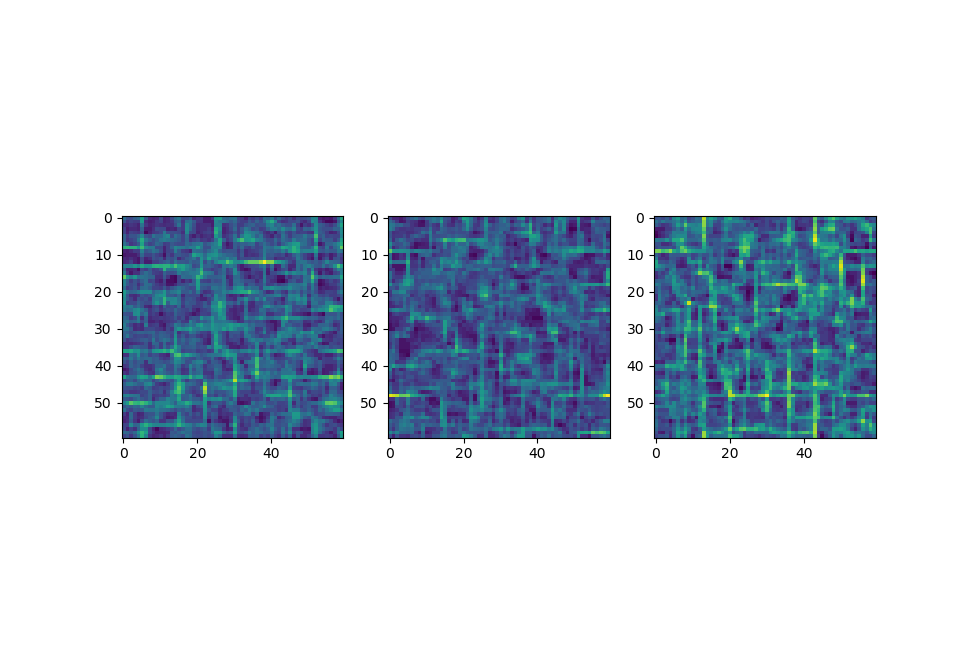

In [42]:
show_grid(grid)

In [90]:
%timeit evolve3D_c(grid, b, num_steps=1)

136 ms ± 6.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [91]:
%timeit evolve3D_c(grid, b, num_steps=10)

1.28 s ± 59.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit evolve3D(grid, b, num_steps=1)

57.7 s ± 1.42 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
B = set()
for i in range(28):
    for j in range(1, 28):
        B.add(i/j + 0.0000000001)
B = list(B)
len(B)

460

In [56]:
Fc = np.zeros((len(B)), dtype=float)
L = 60
c_prob = 0.5
grid = np.random.choice(2, (L, L, L), p=[C_prob, 1 - C_prob])
grid = grid.astype('int16')
for i in range(0, len(B), 10):
    b = B[i]
    grid = np.random.choice(2, (L, L, L), p=[C_prob, 1 - C_prob])
    grid = grid.astype('int16')
    grid = np.array(evolve3D_c(grid, b, num_steps=50))
    print('b =',b)
    for j in range(5):
        grid = np.array(evolve3D_c(grid, b, num_steps=10))
        Fc[i] += (L**3 - grid.sum())/(L**3)
    Fc[i] = Fc[i]/5
    print('Fc =', Fc[i])

b = 1.0384615384615385
Fc = 0.9839444444444444
b = 1.0625
Fc = 0.9828148148148148
b = 1.0952380952380953
Fc = 0.9481064814814815
b = 1.1304347826086956
Fc = 0.930825925925926
b = 1.1666666666666667
Fc = 0.950011111111111
b = 1.2
Fc = 0.9486009259259258
b = 1.25
Fc = 0.9384675925925926
b = 1.2857142857142858
Fc = 0.7977222222222222
b = 1.3333333333333333
Fc = 0.9833333333333332
b = 1.375
Fc = 0.9508287037037035
b = 1.4285714285714286
Fc = 0.0
b = 1.5
Fc = 0.0
b = 1.5454545454545454
Fc = 0.0
b = 1.6153846153846154
Fc = 0.0
b = 1.6875
Fc = 0.0
b = 1.7692307692307692
Fc = 0.0
b = 1.8571428571428572
Fc = 0.0


# Tabulate the neighbors

In [6]:
NUM_NEIGHB = 27

def get_site(coord, L):
    """Get the site index from the 3-vector of coordinates."""
    # XXX: 3D hardcoded, can do N-D
    return coord[0] * L[1] * L[2] + coord[1] * L[2] + coord[2]


def get_coord(site, L):
    """Get the 3-vector of coordinates from the site index."""
    # XXX: 3D hardcoded, can do N-D
    x = site // (L[1]*L[2])
    yz = site % (L[1]*L[2])
    y = yz // L[2]
    z = yz % L[2]
    return [x, y, z]


def get_neighbors(site, L):
    neighb = set()
    x, y, z = get_coord(site, L)
    for i in [-1, 0, 1]:
        for j in [-1, 0, 1]:
            for k in [-1, 0, 1]:
                x1 = (x + i) % L[0]
                y1 = (y + j) % L[1]
                z1 = (z + k) % L[2]
                neighb.add(get_site([x1, y1, z1], L))
    
    return list(neighb)
    
def tabulate_neighbors(L):
    """Tabulate the root-2 neighbors on the 3D cubic lattice with PBC."""
    Nsite = L[0]*L[1]*L[2]
    neighb = np.empty((Nsite, NUM_NEIGHB), dtype=int)
    for site in range(Nsite):
        neighb[site, :] = get_neighbors(site, L)
    return neighb



def tabulate_neighbors_small_L(L):
    """
    Tabulate the root-2 neighbors on the 3D cubic lattice with PBC.
    Must be used when L[0], L[1] or L[2] < 3 
    """
    Nsite = L[0]*L[1]*L[2]
    neighb = [[]] * Nsite
    for site in range(Nsite):
        neighb[site] = get_neighbors(site, L)
    return neighb

In [7]:
# Test conversion sites <--> coords

from numpy.testing import assert_equal

L = (5, 5, 5)
for site in range(L[0] * L[1] * L[2]):
    xyz = get_coord(site, L)
    site1 = get_site(xyz, L)
    #print(site, xyz, site1)
    assert_equal(site, site1)

# TODO: test neighbors (distance w/PBC?)

In [11]:
for nghb in get_neighbors(get_site((2, 2, 2), L), L):
    print(nghb, get_coord(nghb, L), end=" -- ")

31 [1, 1, 1] -- 32 [1, 1, 2] -- 33 [1, 1, 3] -- 36 [1, 2, 1] -- 37 [1, 2, 2] -- 38 [1, 2, 3] -- 41 [1, 3, 1] -- 42 [1, 3, 2] -- 43 [1, 3, 3] -- 56 [2, 1, 1] -- 57 [2, 1, 2] -- 58 [2, 1, 3] -- 61 [2, 2, 1] -- 62 [2, 2, 2] -- 63 [2, 2, 3] -- 66 [2, 3, 1] -- 67 [2, 3, 2] -- 68 [2, 3, 3] -- 81 [3, 1, 1] -- 82 [3, 1, 2] -- 83 [3, 1, 3] -- 86 [3, 2, 1] -- 87 [3, 2, 2] -- 88 [3, 2, 3] -- 91 [3, 3, 1] -- 92 [3, 3, 2] -- 93 [3, 3, 3] -- 

In [8]:
def evolve3D_2(grid, neighbors, b, num_steps=1):
    
    L = grid.shape
    
    grid = grid.flatten()
    SIZE = len(grid)
    current = np.zeros((SIZE), dtype=int)
    scores = np.zeros((SIZE), dtype=float)
    for step in range(num_steps):
        current = grid.copy()
        scores = np.zeros((SIZE), dtype=float)
        for site in range(SIZE):
            # TODO: 
            #       5. cythonize
            for site1 in neighbors[site]:
                scores[site] += (1 - grid[site1])
                
            if grid[site] == 1:
                scores[site] *= b
                
        for site in range(SIZE):
            best_site = site
            for site1 in neighbors[site]:
                if (scores[best_site] < scores[site1]):
                    best_site = site1
                    
            grid[site] = current[best_site]
    return np.reshape(grid, L)

In [11]:
# check that the dynamics is identical
L = (20, 20, 20)

neighbors = tabulate_neighbors_small_L(L)

rndm = np.random.RandomState(12345)

B = set()
for i in range(28):
    for j in range(1, 28):
        if i/j > 1 and i / j < 1.5:
            B.add((i/j) + 0.000000001)
B = sorted(list(B))

N = 5

for i in range(0, len(B), len(B)//10):
    b = B[i]
    field = (rndm.uniform(size=L) > 0.5).astype(int)
    field2 = field.copy()
    field = evolve3D(field.copy(), b, num_steps=N)
    field2 = evolve3D_2(field2.copy(), neighbors, b, num_steps=N)
    assert_equal(field, field2)
    print('Game stabilized:', field.all())

Game stabilized: False
Game stabilized: False
Game stabilized: False
Game stabilized: False
Game stabilized: False
Game stabilized: False
Game stabilized: False
Game stabilized: False
Game stabilized: True
Game stabilized: True
Game stabilized: True


# Test times

In [12]:
L = (60, 60, 60)

neighbors = tabulate_neighbors(L)

rndm = np.random.RandomState(12345)

N = 1

field = (rndm.uniform(size=L) > 0.5).astype(int)

In [146]:
%timeit evolve3D(field, 1.3, num_steps=N)

26.5 s ± 937 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [147]:
%timeit evolve3D_2(field, neighbors, 1.3, num_steps=N)

16.7 s ± 188 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Check that the dynamics is identical to 2D

In [9]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [10]:
%%cython -a

import numpy as np

import cython

@cython.cdivision(True)
@cython.boundscheck(False)
def evolve2_1(long[:, ::1] field, double b, int num_steps=1):
    
    cdef int x, y, L, i, j, ix, jy, step
    
    L = field.shape[0]
    cdef double[:, ::1] scores = np.zeros((L, L), dtype=float)
    
    cdef double[:, ::1] _zeros = np.zeros((L, L), dtype=float)
    cdef long[:, ::1] current = field.copy()
    
    for step in range(num_steps):
        current = field.copy()
        scores[...] = _zeros
        
        for x in range(L):
            for y in range(L):
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        ix = (x + i) % L
                        jy = (y + j) % L
                        scores[x, y] += (1 - field[ix, jy])
                        
                if field[x, y] == 1:
                    scores[x, y] *= b
        
        for x in range(L):
            for y in range(L):
                bestX = x
                bestY = y
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        ix = (x + i) % L
                        jy = (y + j) % L
                        if (scores[bestX, bestY] < scores[ix, jy]):
                            bestX = ix
                            bestY = jy
                
                field[x, y] = current[bestX, bestY]
    return field

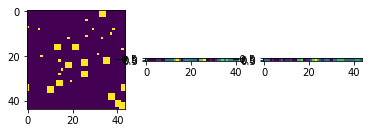

Game stabilized: False


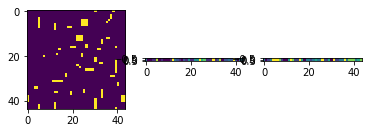

Game stabilized: False


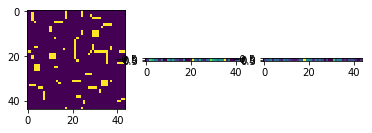

Game stabilized: False


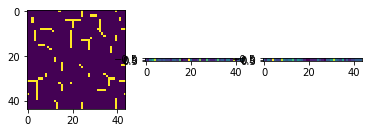

Game stabilized: False


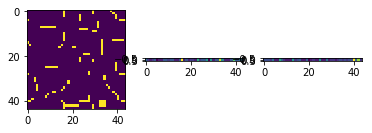

Game stabilized: False


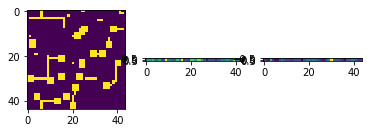

Game stabilized: False


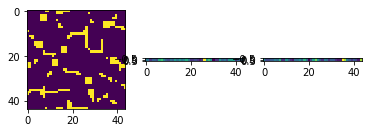

Game stabilized: False


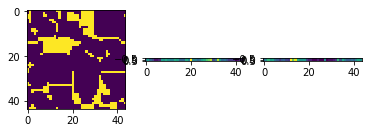

Game stabilized: False


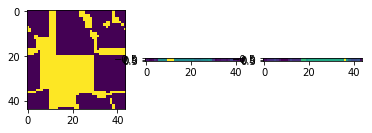

Game stabilized: False


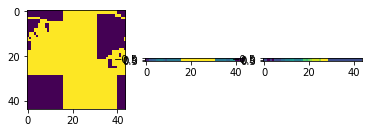

Game stabilized: False


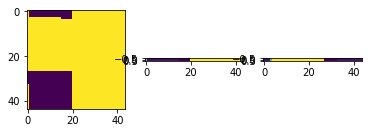

Game stabilized: False


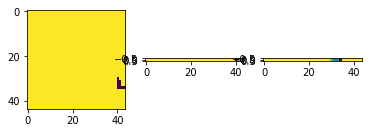

Game stabilized: False


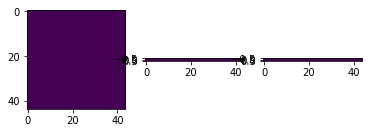

Game stabilized: True


In [15]:

L = (1, 44, 44)

neighbors = tabulate_neighbors_small_L(L)

rndm = np.random.RandomState(12345)

B = set()
for i in range(1, 10):
    for j in range(1, 10):
        if i/j > 1 and i / j < 2:
            B.add((i/j) + 0.000000001)
B = sorted(list(B))

N = 10

for b in B:
    field = (rndm.uniform(size=L) > 0.5).astype(int)
    field2 = field[0, :, :].copy()
    field = evolve3D_2(field, neighbors, b, num_steps=N)
    field2 = np.array(evolve2_1(field2, b, num_steps=N))
    assert_equal(field[0, :, :], field2)
    show_grid(field)
    print('Game stabilized:', field.all())

# Cythonised function

In [10]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [11]:
%%cython -a

import numpy as np

import cython

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
def evolve3D_2_C(grid_orig, long[:, :] neighbors, double b, int num_steps=1):
    
    cdef int N_NEIGHB = 27 
    L = grid_orig.shape
    cdef short[:] grid = grid_orig.flatten()
    
    cdef int SIZE, step, site, site1, best_site, i
    SIZE = L[0] * L[1] * L[2]
    cdef short[:] current = grid.copy()
    cdef double[:] _zeros = np.zeros((SIZE), dtype=float)
    cdef double[:] scores = np.zeros((SIZE), dtype=float)
    
    for step in range(num_steps):
        current = grid.copy()
        scores[...] = _zeros
        for site in range(SIZE):
            # TODO: 
            #       5. cythonize
            for i in range(N_NEIGHB):
                site1 = neighbors[site,i]
                scores[site] += (1 - grid[site1])
                
            if grid[site] == 1:
                scores[site] *= b
        
        for site in range(SIZE):
            best_site = site
            for i in range(N_NEIGHB):
                site1 = neighbors[site,i]
                if (scores[best_site] < scores[site1]):
                    best_site = site1
                    
            grid[site] = current[best_site]
    grid_orig = np.array(grid)
    return np.reshape(grid_orig, L)

In [42]:
# check that the dynamics is identical
L = (10, 10, 10)

neighbors = tabulate_neighbors(L)

rndm = np.random.RandomState(12345)

B = set()
for i in range(28):
    for j in range(1, 28):
        if i/j > 1 and i / j < 1.5:
            B.add((i/j) + 0.000000001)
B = sorted(list(B))

N = 5

for i in range(0, len(B), len(B)//10):
    b = B[i]
    print('b = ', b)
    field = (rndm.uniform(size=L) > 0.5).astype('int16')
    field2 = field.copy()
    field = evolve3D_2_C(field.copy(), neighbors, b, num_steps=N)
    field2 = evolve3D_2(field2.copy(), neighbors, b, num_steps=N)
    assert_equal(field, field2)
    print('Game stabilized:', field.all())

b =  1.0384615394615386
Game stabilized: False
b =  1.0526315799473684
Game stabilized: False
b =  1.0800000010000002
Game stabilized: False
b =  1.1111111121111112
Game stabilized: False
b =  1.150000001
Game stabilized: False
b =  1.187500001
Game stabilized: False
b =  1.230769231769231
Game stabilized: True
b =  1.2777777787777778
Game stabilized: True
b =  1.3333333343333333
Game stabilized: True
b =  1.3846153856153847
Game stabilized: True
b =  1.437500001
Game stabilized: True


# Time comparison

In [ ]:
import timeit

In [38]:
rndm = np.random.RandomState(12345)
N = 1
N_repeats = 3
times = list()
times_C = list()
for size in range(10, 80, 10):
    L = (size, size, size)
    print(L)
    neighbors = tabulate_neighbors(L)
    field = (rndm.uniform(size=L) > 0.5).astype('int16')
    times_C.append(timeit.timeit('evolve3D_2_C(field, neighbors, 1.3, num_steps=N)', number=N_repeats, globals=globals()) / N_repeats)
    times.append(timeit.timeit('evolve3D_2(field, neighbors, 1.3, num_steps=N)', number=N_repeats, globals=globals()) / N_repeats)
    print(times_C[-1])
    print(times[-1])

(10, 10, 10)
0.0003042333332814451
0.2786005999999664
(20, 20, 20)
0.0020136333334145697
2.1643250666666063
(30, 30, 30)
0.007317133333344827
7.400840066666508
(40, 40, 40)
0.016232433333243534
17.058701766666672
(50, 50, 50)
0.0346767666666589
32.87892993333359
(60, 60, 60)
0.06662443333334522
56.15200533333336
(70, 70, 70)
0.09761379999993854
92.11719569999998


<IPython.core.display.Javascript object>


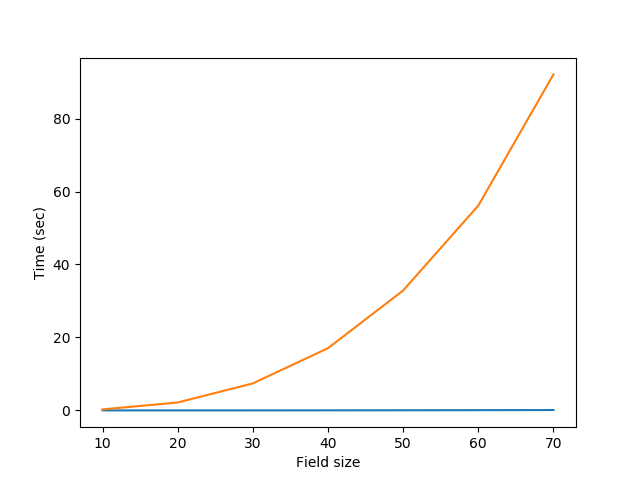

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Field size')
ax.set_ylabel('Time (sec)')
ax.plot([10, 20, 30, 40, 50, 60, 70], times_C)
ax.plot([10, 20, 30, 40, 50, 60, 70], times)


plt.show()

In [68]:
time_div = list()
for i in range(len(times)):
    time_div.append(times[i] / times_C[i])

<IPython.core.display.Javascript object>


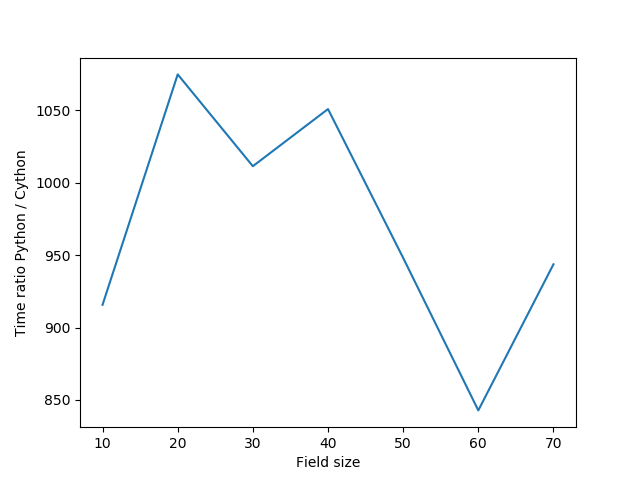

In [70]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Field size')
ax.set_ylabel('Time ratio Python / Cython')
ax.plot([10, 20, 30, 40, 50, 60, 70], time_div)


plt.show()

# Use prange

In [63]:
%%cython -a

import numpy as np
from cython.parallel import prange
import cython

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
def evolve3D_3_C(grid_orig, long[:, :] neighbors, double b, int num_steps=1):
    
    cdef int N_NEIGHB = 27 
    L = grid_orig.shape
    cdef short[:] grid = grid_orig.flatten()
    
    cdef int SIZE, step, site, site1, best_site, i
    SIZE = L[0] * L[1] * L[2]
    cdef short[:] current = grid.copy()
    cdef double[:] _zeros = np.zeros((SIZE), dtype=float)
    cdef double[:] scores = np.zeros((SIZE), dtype=float)
    
    for step in prange(num_steps):
        current = grid.copy()
        scores[...] = _zeros
        for site in range(SIZE):
            # TODO: 
            #       5. cythonize
            for i in prange(N_NEIGHB):
                site1 = neighbors[site,i]
                scores[site] += (1 - grid[site1])
                
            if grid[site] == 1:
                scores[site] *= b
        
        for site in prange(SIZE):
            best_site = site
            for i in prange(N_NEIGHB):
                site1 = neighbors[site,i]
                if (scores[best_site] < scores[site1]):
                    best_site = site1
                    
            grid[site] = current[best_site]
    grid_orig = np.array(grid)
    return np.reshape(grid_orig, L)


Error compiling Cython file:
------------------------------------------------------------
...
        
        for site in prange(SIZE):
            best_site = site
            for i in prange(N_NEIGHB):
                site1 = neighbors[site,i]
                if (scores[best_site] < scores[site1]):
                          ^
------------------------------------------------------------

C:\Users\romic\.ipython\cython\_cython_magic_c27fa0d20dc8c273f6cfb4d144783b4d.pyx:38:27: local variable 'best_site' referenced before assignment

Error compiling Cython file:
------------------------------------------------------------
...
    cdef short[:] current = grid.copy()
    cdef double[:] _zeros = np.zeros((SIZE), dtype=float)
    cdef double[:] scores = np.zeros((SIZE), dtype=float)
    
    for step in prange(num_steps):
        current = grid.copy()
       ^
------------------------------------------------------------

C:\Users\romic\.ipython\cython\_cython_magic_c27fa0d20dc8c273f6cfb4d1

TypeError: object of type 'NoneType' has no len()

# Numba jit

In [12]:
import numba

In [48]:
def evolve3D_3(grid, neighbors, b, num_steps=1):
    L = field.shape
    grid = grid.flatten().astype(int)
    SIZE = len(grid)
    _zeros = np.zeros((SIZE), dtype=float)
    _int_zeros = np.zeros((SIZE), dtype=int)
    evolve3D_impl(grid, neighbors, b, num_steps, _zeros, _int_zeros)
    
    return np.reshape(grid, L)

@numba.jit(nopython=True)
def evolve3D_impl(grid, neighbors, b, num_steps, _zeros, _int_zeros):
    
    L = grid.shape
    
    SIZE = len(grid)
    current = _int_zeros.copy()
    scores = _zeros.copy()
    for step in range(num_steps):
        current = grid.copy()
        scores = _zeros.copy()
        for site in range(SIZE):
            for site1 in neighbors[site]:
                scores[site] += (1 - grid[site1])
                
            if grid[site] == 1:
                scores[site] *= b
                
        for site in range(SIZE):
            best_site = site
            for site1 in neighbors[site]:
                if (scores[best_site] < scores[site1]):
                    best_site = site1
                    
            grid[site] = current[best_site]
    return grid

In [49]:
import timeit
rndm = np.random.RandomState(12345)
N = 1
Size = 60
L = (Size, Size, Size)
print(L)
neighbors = tabulate_neighbors(L)
field = (rndm.uniform(size=L) > 0.5).astype(int)
field = evolve3D_3(field, neighbors, 1.3, num_steps=N)

(60, 60, 60)


In [ ]:
field = evolve3D_3(field, neighbors, 1.3, num_steps=100)

In [ ]:
show_grid(field)

In [47]:
%timeit evolve3D_3(field, neighbors, 1.3, num_steps=1)

70.6 ms ± 5.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Time comparison

In [52]:
rndm = np.random.RandomState(12345)
N = 1
N_repeats = 10
times = list()
times_C = list()
for size in range(10, 80, 10):
    L = (size, size, size)
    print(L)
    neighbors = tabulate_neighbors(L)
    field = (rndm.uniform(size=L) > 0.5).astype('int16')
    times_C.append(timeit.timeit('evolve3D_2_C(field, neighbors, 1.3, num_steps=N)', number=N_repeats, globals=globals()) / N_repeats)
    times.append(timeit.timeit('evolve3D_3(field, neighbors, 1.3, num_steps=N)', number=N_repeats, globals=globals()) / N_repeats)
    print(times_C[-1])
    print(times[-1])

(10, 10, 10)
0.0004658899999867572
0.000349850000020524
(20, 20, 20)
0.002833390000023428
0.0016478800000186312
(30, 30, 30)
0.01025168000001031
0.006889130000035948
(40, 40, 40)
0.03010255999997753
0.024888719999989917
(50, 50, 50)
0.045702889999984106
0.04808189999998831
(60, 60, 60)
0.07996495000002142
0.07435855000003358
(70, 70, 70)
0.12066221000000041
0.10780005999999957


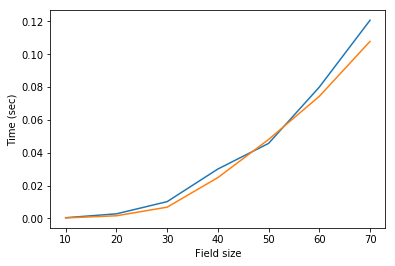

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Field size')
ax.set_ylabel('Time (sec)')
ax.plot([10, 20, 30, 40, 50, 60, 70], times_C)
ax.plot([10, 20, 30, 40, 50, 60, 70], times)


plt.show()

In [54]:
time_div = list()
for i in range(len(times)):
    time_div.append(times[i] / times_C[i])

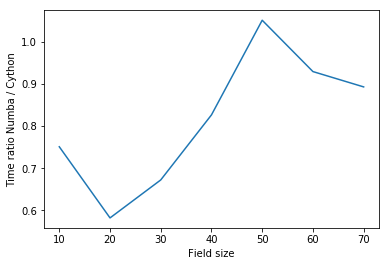

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Field size')
ax.set_ylabel('Time ratio Numba / Cython')
ax.plot([10, 20, 30, 40, 50, 60, 70], time_div)


plt.show()